In [113]:
# RANC: Income Fluctuation Problem with Occasionally Binding Constraints
# With Time Iteration and Endogenous Grid Method

# Problem: V(a,y) = max u(c)+βE[V(a',y')|y]
# s.t. c + a' = (1+r)a + y, c>=0, a'>= lb
# y'\y ~ N
# Euler: u'(c(a,y)) = β(1+r)E[u'(c(a',y'))]     (> if a'=0)

# Time Iteration: from r, c(a',y'), β, P get c(a,y)
# c(a,y) = invup  β(1+r) dot(P,u'(c(a',y')))

using Distributions, BenchmarkTools, Parameters, Interpolations, LinearAlgebra
import Random
Random.seed!(1234)

Random.TaskLocalRNG()

In [107]:
# Shock Process Discretization
function tauchen(μ,σ,ρ,N)
    σ_ = σ/(1-ρ^2)^0.5    
    zu = μ + 3*σ
    zl = μ - 3*σ
    Z = collect(range(zl, zu, N))
    M = (Z[1:end-1]+Z[2:end])/2
    z = Normal(0, 1)
    P = zeros(N,N)
    for i in 2:N-1
        for j in 2:N-1
            P[i,j] = cdf(z, (M[j]-(1-ρ)*μ-ρ*Z[i])/σ)-cdf(z, (M[j-1]-(1-ρ)*μ-ρ*Z[i])/σ)
        end
    end

    P[:,1] = [cdf(z, (M[1]-(1-ρ)*μ-ρ*z_)/σ) for z_ in Z]
    P[:,end] = [(1-cdf(z, (M[end-1]-(1-ρ)*μ-ρ*z_)/σ)) for z_ in Z]
    return Z, P
    end

tauchen (generic function with 1 method)

In [154]:
# Parameters
ub = 200 # upper bound for assets
lb = 0 # lower bound for assets (can be negative)
β = 0.98 # patience
α = 0.11 # share of capital in income
δ = 0.025 # depreciation
γ = 0.5 # elasticity of substitution
r = 0.05 # interest rate

# Utility Function Tools
u(c, γ) = c.^(1-γ)/(1-γ) # period utility
up(c, γ) = c.^-γ # marginal utility
invup(up, γ) = up.^(-1\γ) # inverse of marginal utility

# Income Process
ρ = 0.966
N_Y = 7
σ = 0.13
σ = σ/sqrt(1-ρ^2)
μ = 0
P, Y = rowenhorst(μ,σ,ρ,N_Y) # Shock Space and Transition Matrix

# Asset and Income Grids
N_A = 100

function getGrids(ub, lb, N_A, N_Y, Y)
    Agrid = [i for i in range(lb, ub, N_A), j in 1:N_Y]
    Ygrid = [j for i = 1:N_A, j in Y]
    return Agrid, Ygrid
end

Agrid, Ygrid = getGrids(ub, lb, N_A, N_Y, Y)

getCfromEuler(γ, β, P, r, cp) = invup(β .* (1+r).*up(cp, γ)  * P' , γ) 
getAfromBudget(Agrid, Ygrid, r, w, c) =  1/(1+r) .* (c .+ Agrid .- w*Ygrid)

getAfromBudget (generic function with 1 method)

In [155]:
r, tol,  maxiter, Z, w = (1-alpha)*Z*(alpha*Z/(r+deprec))^(alpha/(1-alpha)) # wage rate given guess for r
cnext = @. r*Amat+Ymat*w # initial guess for policy function iteration 
cbinding = @. (1+r)*Amat + w*Ymat - bc # get consumption when borrowing constraint binds
rnext = r
cpolicy = similar(Amat)


LoadError: MethodError: no method matching -(::Int64, ::typeof(alpha))
[0mClosest candidates are:
[0m  -(::Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/int.jl:85
[0m  -(::T, [91m::T[39m) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/int.jl:86
[0m  -(::Union{Int16, Int32, Int64, Int8}, [91m::BigInt[39m) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/gmp.jl:537
[0m  ...

Policy Function Converged

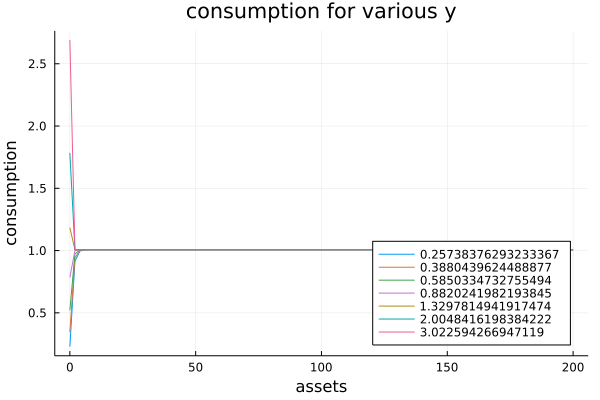

In [160]:
function EGM(γ, β, P, Agrid, Ygrid, N_A, N_Z, w, r, rp, cp, c_bind)
    c = getCfromEuler(γ, β, P, r, cp)
    a = getAfromBudget(Agrid, Ygrid, r, w, cp)
    c_nonbind = similar(Agrid)
    for i in 1:N_Z
        c_nonbind[:, i] = LinearInterpolation(a[:,i], c[:,i], extrapolation_bc = Line()).(Agrid[:,i])
    end
    for j in 1:N_Z
        c[:,j] = (Agrid[:,j] .> a[1,j]) .* c_nonbind[:,j] .+ (Agrid[:,j] .<= a[1,j]).* c_bind[:,j]
    end
    ap = @. (1+r)*Agrid + w*Ygrid - c
    return c, ap
end
  
r = 0.01
tol=1e-8
maxiter=1000
cpolicy = similar(Agrid)

Z = ((r + δ)/α)^α 
w = (1-α)*Z*(α*Z/(r+δ))^(α/(1-α))
cp = @. r*Agrid+Ygrid*w 
c_bind = @. (1+r)*Agrid + w*Ygrid - lb 
rp = r
for i in 1:maxiter
    c, ap = EGM(γ, β, P, Agrid, Ygrid, N_A, N_Y, w, r, rp, cp, c_bind)
    if norm(c-cp,Inf)<tol
        print("Policy Function Converged")
        cpolicy = copy(c)
        break
    else
        cp = c
    end
end

plot(Agrid[:,1], cpolicy, label = Y', xlabel = "assets", ylabel = "consumption", title = "consumption for various y", legend = :bottomright)

In [157]:
Z = ((r + δ)/α)^α # agg Y normalised to 1
w = ((1-α)*Z*(α*Z)/(r+δ))^(α/(1-α)) # wages given r
cp = @. r*Agrid+Ygrid*w # Initial Guess, Save nothing
c_bind = @. (1+r)*Agrid + w*Ygrid - lb # consumption when borrowing constraint binds (a' = lb)
rp = r

for i in 1:maxiter
    c, ap = EGM(γ, β, P, Agrid, Ygrid, N_A, N_Y, w, r, rp, cp, c_bind)
    if norm(c-cp,Inf)<tol
        print("Policy Function Converged")
        return EGM(γ, β, P, Agrid, Ygrid, N_A, N_Y, w, r, rp, cp, c_bind)
    else
        cp = c
    end
end



plot(Agrid[:,1], cpolicy, label = ygrid', xlabel = "assets", ylabel = "consumption", title = "consumption for various y", legend = :bottomright)

LoadError: knot-vectors must be unique and sorted in increasing order

In [158]:
function TimeIteration(r, tol=1e-8, maxiter=1000)
    Z = ((r + δ)/α)^α # agg Y normalised to 1
    w = ((1-α)*Z*(α*Z)/(r+δ))^(α/(1-α)) # wages given r
    cp = @. r*Agrid+Ygrid*w # Initial Guess, Save nothing
    c_bind = @. (1+r)*Agrid + w*Ygrid - lb # consumption when borrowing constraint binds (a' = lb)
    rp = r
    
    for i in 1:maxiter
        c, ap = EGM(γ, β, P, Agrid, Ygrid, N_A, N_Y, w, r, rp, cp, c_bind)
        if norm(c-cp,Inf)<tol
            print("Policy Function Converged")
            return EGM(γ, β, P, Agrid, Ygrid, N_A, N_Y, w, r, rp, cp, c_bind)
        else
            cp = c
        end
    end
end

c, ap = TimeIteration(0.01)

LoadError: knot-vectors must be unique and sorted in increasing order

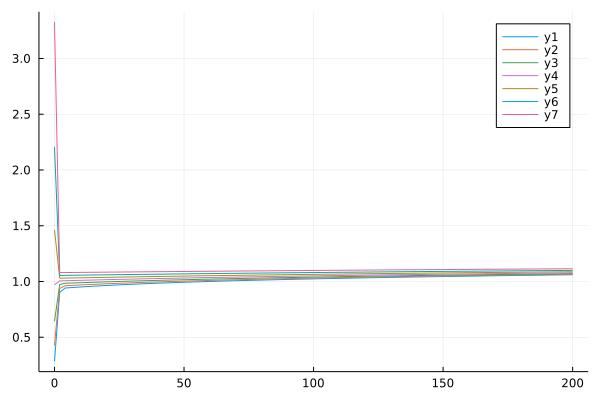

In [159]:
using Plots
plot(Agrid[:,1], c)

In [ ]:

plot(Amat[:,1], c, label = ygrid', xlabel = "assets", ylabel = "consumption", title = "consumption for various y", legend = :bottomright)

In [83]:
c

100×7 Matrix{Float64}:
 1.10075  1.10075  1.10075  1.10075   1.10075   1.10075   1.10075
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.09235
 ⋮                                              ⋮         
 1.44892  1.02805  1.00328  0.967059  0.898562  0.850055  1.

In [117]:

function rowenhorst(mean, uncond_sd, rho, num_states)
    """
    Rowenhort's method to approximate AR(1) process with Markov chain (ln y_t = mu + rho y_{t-1} + e_t)
    Note: this function also normalizes effective labour to one.
    
    #### Fields
    
    - 'mean': unconditional mean of income process
    - 'uncond_sd': unconditional standard deviation
    - 'rho': autocorrelation coefficient
    - 'num_states': number of states we want discretized
    
    #### Returns
    
    - 'transition_matrix': num_states x num_states array where
    transition_matrx[i,j] is prob. of going from i to j
    - 'ygrid': vector of income state space of length num_states
    
    """
    
    # construct grids
    step_r = uncond_sd*sqrt(num_states-1)
    ygrid = -1:2/(num_states-1):1
    ygrid = mean .+ step_r*ygrid
    
    # initialize transition probabilities 
    p = (rho+1)/2
    q = p
    
    transition_matrix = [p 1-p; 1-q q]
    
    # rowenhort's method
    for i = 2:num_states-1
        a1 = [transition_matrix zeros(i, 1); zeros(1, i+1)] 
        a2 = [zeros(i,1) transition_matrix; zeros(1, i+1)]
        a3 = [zeros(1, i+1); transition_matrix zeros(i,1)]
        a4 = [zeros(1, i+1); zeros(i,1) transition_matrix]
        
        transition_matrix = p*a1 + (1-p)*a2 + (1-q)*a3 + q*a4
        transition_matrix[2:i, :] = transition_matrix[2:i, :]/2
    end
    
    for i = 1:num_states
       transition_matrix[i,:] = transition_matrix[i,:]/sum(transition_matrix[i,:])
    end
    
    # get stationary distribution to normalize effective labour to L=1
    pi = eigvecs(transition_matrix')[:,num_states]
    
    # normalize pi
    pi = pi./sum(pi)
    
    # exponentiate
    ygrid = exp.(ygrid)
    
    # normalize effective labour
    ygrid = ygrid/sum(pi.*ygrid)
    
    return transition_matrix, ygrid
end

rowenhorst (generic function with 1 method)